In [43]:
import cv2 as cv
# import network
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from typing import Tuple
class network:
    def __init__(self, nodeNumber:tuple, learningRate:float,softmax=False,dropout=[]):
        self.learningRate = learningRate
        self.step=0
        # self.target:np.array = np.zeros(outputNodeNumber)
        self.enableSoftmax=softmax
        self.dropout={}
        for i in dropout:
            self.dropout[i[0]]=i[1]
        self.mask={}
        self.nodeNumber=nodeNumber
        self.layerNumber=len(nodeNumber)
        self.layer=[]
        for i in range(self.layerNumber):
            self.layer.append(np.zeros((nodeNumber[i],1)))

        self.weight=[]
        self.const=[]
        for i in range(self.layerNumber-1):
            self.weight.append(np.random.uniform(-1, 1, (nodeNumber[i+1],nodeNumber[i]))/np.sqrt(nodeNumber[i]))
            self.const.append(-np.random.uniform(-1,0,size=(nodeNumber[i+1],1)))
        self.const[-1]=np.random.uniform(-0.2,0.2,(nodeNumber[-1],1))
        
        
        print("init done")
        
    def normalize(self,data:np.ndarray)->np.ndarray:
        maxData = np.max(data)
        minData = np.min(data)
        return (data-minData)/(maxData-minData)    
        
    def denormalize(self, data:np.ndarray,min,max)->np.ndarray:
        minData = np.min(data)
        maxData = np.max(data)
        return data / (maxData - minData) * (max - min) + min
    
    def sigmod(self,x:np.ndarray)->np.ndarray:
        return 1/(1+np.exp(-x))
    
    def sigmodDerivative(self,f:np.ndarray)->np.ndarray:
        return f*(1-f)
    
    def forwardPropagation(self,input:np.ndarray)->np.ndarray:
        self.mask={}
        self.layer[0]=input
        for layerNumber in range(self.layerNumber-2):
            self.layer[layerNumber+1]=self.weight[layerNumber].dot(self.layer[layerNumber])+self.const[layerNumber]
            self.layer[layerNumber+1]=self.sigmod(self.layer[layerNumber+1])
            if layerNumber+1 in self.dropout:
                mask=np.random.binomial(1/(1-self.dropout[layerNumber+1]),1-self.dropout[layerNumber+1],size=self.layer[layerNumber+1].shape)
                self.mask[layerNumber+1]=mask
                self.layer[layerNumber+1]*=mask
                # 把这个放到weight上
        self.layer[-1]=self.weight[-1].dot(self.layer[-2])+self.const[-1]
        if self.enableSoftmax:
            self.layer[-1]=self.softmax(self.layer[-1])
        else:
            self.layer[-1]=self.sigmod(self.layer[-1])
        return self.layer[-1]

    def backPropagation(self,target:np.ndarray):
        delta=[None]*(self.layerNumber)
        if self.enableSoftmax:
            delta[self.layerNumber-1]=(self.layer[-1]-target)/len(target)
        else:
            delta[self.layerNumber-1]=(self.layer[self.layerNumber-1]-target)*self.sigmodDerivative(self.layer[self.layerNumber-1])
        for i in range(self.layerNumber-2,0,-1):
            delta[i]=np.dot(self.weight[i].T,delta[i+1])*self.sigmodDerivative(self.layer[i])
            # if i in self.mask:
            #     delta[i]*=self.mask[i]
        for i in range(self.layerNumber-1):
            if i+1 in self.mask:
                self.weight[i]-=self.learningRate*(delta[i+1]*self.mask[i+1]).dot(self.layer[i].T)
            else:
                self.weight[i]-=self.learningRate*delta[i+1].dot(self.layer[i].T)
            self.const[i]-=self.learningRate*delta[i+1]
        
            
    def error(self,output,target)->float:
        return np.sum(np.square(target-output))/2
    
    def crossEntropy(self,output:np.ndarray,target:np.ndarray)->float:
        return -np.average(target*np.log(output))
    
    def learningRateDecline(self):
        self.learningRate /= (1+self.decay)
        

    def train(self,input:np.ndarray, target:np.ndarray)->float:
        self.step+=1
        output=self.forwardPropagation(input)
        self.backPropagation(target)
        self.learningRateDecline()
        return self.error(output,target)
        
    def prepoccess(self,input:np.ndarray,normalize:bool=False,reshape=False)->np.ndarray:
        if normalize:
            input=self.normalize(input)
        if reshape:
            input=input.reshape((len(input),1))
        return input
    
    def dump(self,filename:str):
        np.savez(filename, x=np.array(self.weight, dtype=object),y=np.array(self.const, dtype=object), allow_pickle=True)
        
    def load(self,filename:str):
        file=np.load(filename, allow_pickle=True)
        self.weight=file["x"]
        self.const=file["y"]
        
    def softmax(self,x:np.ndarray)->np.ndarray:
        return np.exp(x)/np.sum(np.exp(x))

In [44]:
curPath=os.path.abspath('')
trainPath=curPath+"/../train"
print(trainPath)
def getImg(character:int,number:int)->Tuple[np.ndarray,np.ndarray]:
    imgPath=trainPath+"/"+str(character)+"/"+str(number)+".bmp"
    img=cv.imread(imgPath,0)
    return imgPrepocess(img,character)

def imgPrepocess(img:cv.Mat,character:int)->Tuple[np.ndarray,np.ndarray]:
    ret=np.array(img).flatten()
    out=np.zeros(12)
    out[character-1]=1
    return (ret&1,out)

def showFig(stepArray,lossArray,accuracyArray):
    fig = plt.figure()
    # plt.plot(stepArray,lossArray)
    ax1 = fig.add_subplot(121)
    l1=ax1.plot(stepArray, lossArray, color='red', label='Loss')
    plt.title('BP Loss')
    plt.legend()
    
    ax2=fig.add_subplot(122)
    l2=ax2.plot(stepArray,accuracyArray,color='blue',label='Accuracy')
    plt.title('BP Accuracy')
    plt.legend()
    plt.show()
    
def test(net:network,testSet:list):
    count=0
    for i in testSet:
        input,target=getImg(i[0],i[1])
        input=net.prepoccess(input,reshape=True)
        output=net.forwardPropagation(input)
        if output.argmax()==i[0]-1:
            count+=1
    return count/len(testSet)
               

/Users/jiaruiye/Desktop/FDU/专业课程/必修课程/人工智能/Projects/PJ1/Part1/../train


In [45]:
net=network((28**2,100,20,12),0.05,softmax=True)
trainSet=[]
for i in range(1,13):
    for j in range(1,int(620*0.9+1)):
        trainSet.append((i,j))
testSet=[]
for i in range(1,13):
    for j in range(int(620*0.9+1),621):
        testSet.append((i,j))
trainSize=int(620*12*0.9)
lossArray=[]
stepArray=[]
accuracyArray=[]
lastLoss=0
epoch=0


init done


In [46]:
net.load(curPath+"/characterClassifier-80.npz")

In [48]:
for i in range(10):
    try:
        random.shuffle(trainSet)
        # net.learningRate=np.cos(epoch/20*np.pi)*0.015+0.0151
        net.learningRate=0.01
        for item in trainSet:
            input,target=getImg(item[0],item[1])
            # j=random.randint(1,trainSize)
            # input,target=getImg(dataSet[j][0],dataSet[j][1])
            input,target=net.prepoccess(input,reshape=True),net.prepoccess(target,reshape=True)
            # output=net.forwardPropagation(input)
            output=net.forwardPropagation(input)
            net.backPropagation(target)
            net.step+=1
            
            
        epoch=net.step/trainSize
        loss=net.crossEntropy(output,target)
        accuracy=test(net,trainSet)
        lossArray.append(loss)
        # stepArray.append(net.step)
        stepArray.append(epoch)
        accuracyArray.append(accuracy)
        test_accuracy=test(net,testSet)
        # print("step={} loss={} accuracy={}".format(net.step,loss,accuracy))
        print("epoch={} loss={} accuracy={} test accuracy={} lr={}".format(int(epoch),loss,accuracy,test_accuracy,net.learningRate))
        if abs(lastLoss-loss)<0.000001 and loss < 0.00001 and accuracy>0.99:
            break
        else:
            lastLoss=loss
    except KeyboardInterrupt:
        break

epoch=11 loss=9.885142150126062e-05 accuracy=0.9994026284348865 test accuracy=0.8723118279569892 lr=0.01
epoch=12 loss=5.369676080953578e-05 accuracy=0.9994026284348865 test accuracy=0.8723118279569892 lr=0.01
epoch=13 loss=0.000380820229491518 accuracy=0.9994026284348865 test accuracy=0.8736559139784946 lr=0.01
epoch=14 loss=5.1931354795490975e-06 accuracy=0.9994026284348865 test accuracy=0.8696236559139785 lr=0.01
epoch=15 loss=0.00027689631225963194 accuracy=0.9994026284348865 test accuracy=0.8696236559139785 lr=0.01
epoch=16 loss=9.658342345433892e-06 accuracy=0.9994026284348865 test accuracy=0.8723118279569892 lr=0.01
epoch=17 loss=1.963921729699996e-05 accuracy=0.9994026284348865 test accuracy=0.8723118279569892 lr=0.01
epoch=18 loss=0.0011980880514744707 accuracy=0.9994026284348865 test accuracy=0.8682795698924731 lr=0.01
epoch=19 loss=0.0015407430280433676 accuracy=0.9994026284348865 test accuracy=0.8682795698924731 lr=0.01
epoch=20 loss=8.168604514283412e-05 accuracy=0.9994026

In [11]:
DataSet=[]
for i in range(1,13):
    for j in range(1,621):
        DataSet.append((i,j))

accuracy=test(net,DataSet)
print("Accuracy={}%".format(100.*accuracy))

Accuracy=66.97580645161291%


In [35]:
net.dump(curPath+"/characterClassifier-80.npz")

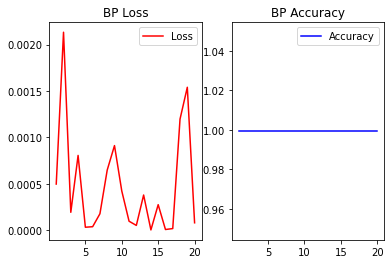

In [49]:
showFig(stepArray,lossArray,accuracyArray)